<a href="https://colab.research.google.com/github/sysyJEON/class_ai4ml/blob/main/ml_guide/ch05_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.9 회귀 실습 - 자전거 대여 수요 예측

캐글의 자전거 대여 수요(Bike Sharing Demand) 예측 학습 데이터 세트를 이용해 선형 회귀와 트리 기반 회귀 비교
- 결정 값은 맨 마지막 칼럼인 count(대여 횟수)

- datetime: hourly date + timestamp  
- season:  1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday: whether the day is considered a holiday
- workingday: whether the day is neither a weekend nor holiday
- weather
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: temperature in Celsius
- atemp: "feels like" temperature in Celsius
- humidity: relative humidity
- windspeed: wind speed
- casual: number of non-registered user rentals initiated
- registered: number of registered user rentals initiated
- count: number of total rentals

### 데이터 클렌징 및 가공과 데이터 시각화

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/content/drive/MyDrive/데이터/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


- 해당 데이터 세트는 10886개의 레코드와 12개의 칼럼으로 구성됨

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 대부분 칼럼이 int, float 숫자형인데, datetime 칼럼만 object형

Datetime 칼럼 가공 필요
- '년-월-일 시:분:초' 문자 형식을 년, 월, 일, 시간 4개의 속성으로 분리

In [4]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


- 새롭게 year, month, day, hour 칼럼 추가됨

datetime 칼럼 삭제, casual과 registered 칼럼 삭제
- casual 칼럼은 사전 등록하지 않은 사용자의 대여, registered는 등록한 사용자의 대여
- casual + registered = count 이므로 필요 없음

In [5]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

주요 칼럼별로 Target값인 count가 어떻게 분포되어 있는지 시각화

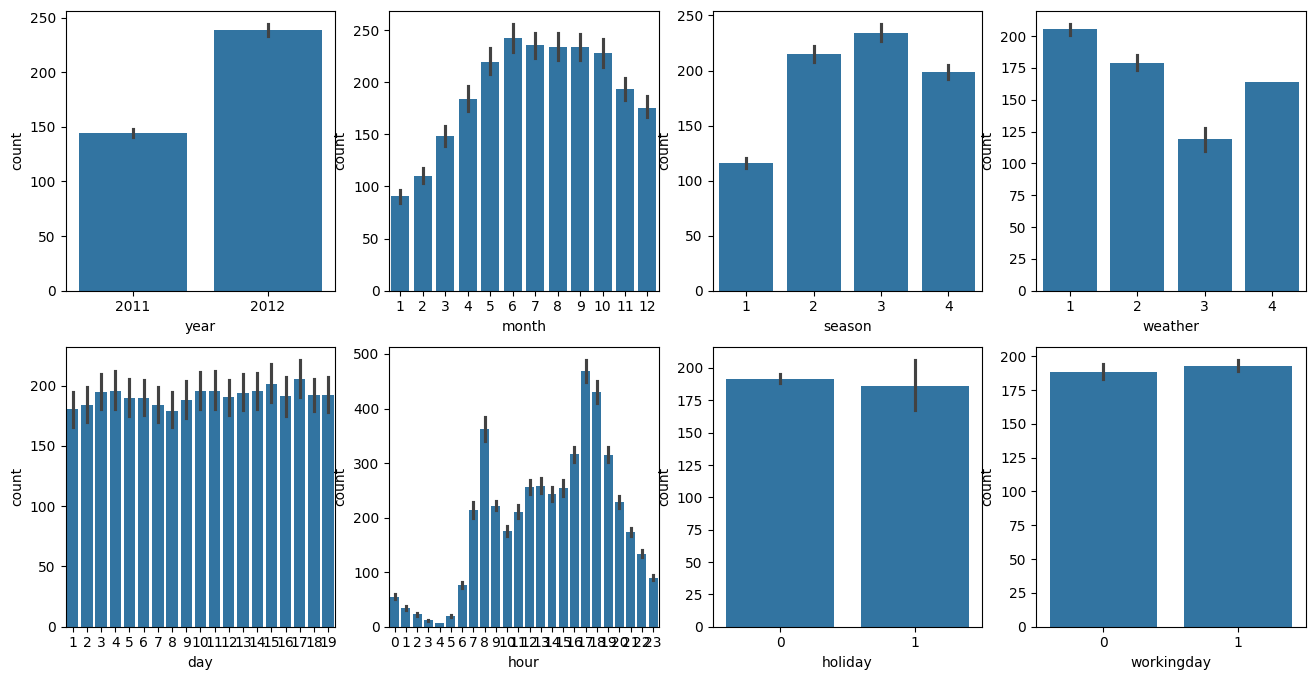

In [6]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

- year: 2012년이 2011년보다 상대적으로 높음 -> 시간이 지날수록 자전거 대여 횟수 증가
- month: 1, 2, 3월 낮고ㅡ 6, 7, 8, 9월 높음
- season: 봄(1), 겨울(4) 낮고, 여름(2), 가을(3) 높음
- weather: 눈 또는 비가 있는 경우(3, 4) 낮고, 맑거나(1) 약간 안개 있는 경우(2) 높음
- hour: 오전 출근 시간(8), 오후 퇴근 시간(17, 18) 높음
- day: 차이 크지 않음
- holiday, workingday: 주중(holiday 0, workingday 1)일 경우 높음

다양한 회귀 모델을 데이터 세트에 적용해 에측 성능 평가
- RMSLE(Root Mean Square Log Error)로 성능 평가
- 오류 값의 로그에 대한 RMSE

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산 <- 오버플로/언더플로 문제 해결(5.10 설명 참고)
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가

회귀 모델 적용 전 처리해야 할 사항
- 결괏값이 정규 분포인지 확인
- 카테고리형 회귀 모델 경우 원-핫 인코딩으로 피처 인코딩하기

먼저 사이킷런의 LinearRegression 객체로 회귀 예측

In [9]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


- 실제 Target 데이터 값인 대여 횟수(Count) 감안하면 예측 오류 비교적 큰 값

실제 값과 예측값이 어느 정도 차이 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개 확인

In [10]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


- 차이가 546~658로 실제 값 감안하면 예측 오류가 큼

Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인

<Axes: >

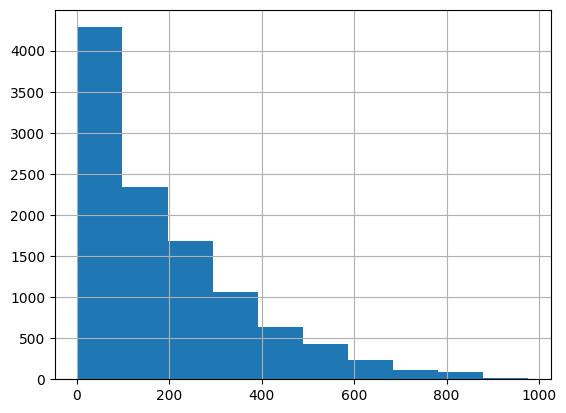

In [11]:
y_target.hist()

- 정규 분포가 아닌 0~20 사이에 왜곡됨

넘파이의 `log1p()`를 이용해 로그 변환 후 분포 확인

<Axes: >

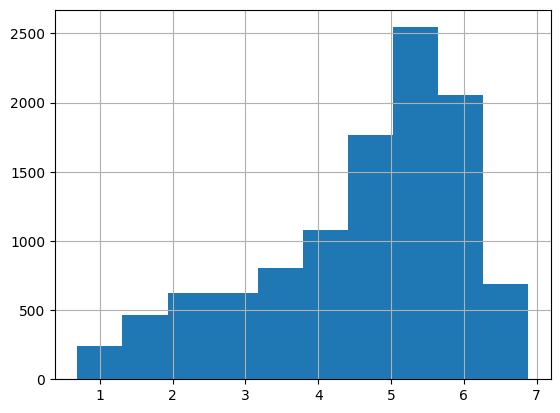

In [12]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

- 정규 분포 형태는 아니지만 변환 전보다 왜곡 정도가 향상

In [13]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- RMSKE 오류 줄었지만, RMSE 오히려 증가

개별 피처들의 인코딩 적용
- 먼저 각 피처의 회귀 계숫값 시각화

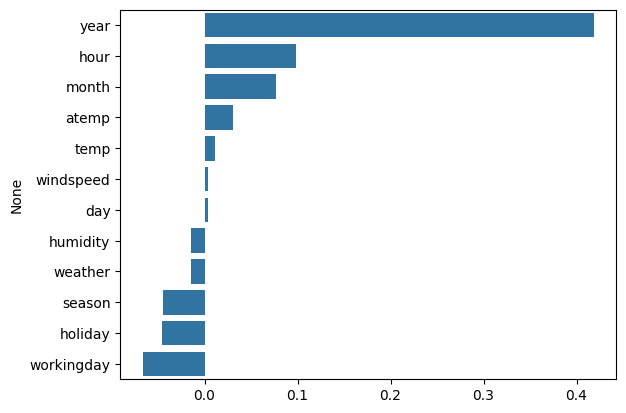

In [14]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

- year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높음
- year는 2011, 2012 값, month는 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 와 같이 숫자값 형태
- 개별 숫자값의 크기가 의미 있는 것은 아니고 단순 연도와 월을 의미
- 즉 year, hour, month 등은 숫자 값으로 표현되었지만 모두 카테고리형 피처

카테고리형 피처에 원-핫 인코딩 적용

In [15]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])



In [16]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


- 예측 성능 향상됨

회귀 계수 상위 20개 피처 추출

<Axes: ylabel='None'>

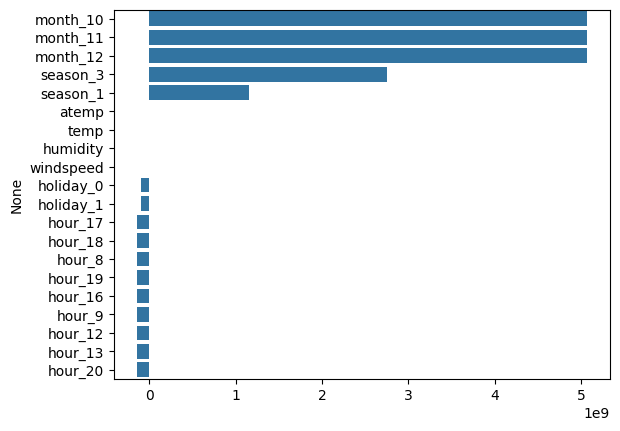

In [17]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

- 피처들의 영향도 달라지고 모델의 성능도 향상됨

회귀 트리를 이용해 회귀 예측 수행
- Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트 그대로 이용
- 랜덤포레스트, GBM, XGBoost, LightGBM 성능 평가

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.127, MAE: 31.101
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.331, MAE: 32.739
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


- 선형 회귀 모델보다 예측 성능 개선됨
- 하지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아님